In [1]:
from importlib import reload  # Python 3.4+

import sys
sys.path.append("..")
import helper.helper as h
import helper.methods as m
import pickle
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from timeit import default_timer as timer
import itertools

### Generating Data
Parameters:
- $p$, number of variables.
- $s$, number of arcs.
- $|s|$, size of autoregressive coefficients.
- $T$, number of timesteps.

In [2]:
import math

[[ 0.5  0.   0.  ...  0.5  0.   0.5]
 [ 0.   0.5  0.  ...  0.   0.   0. ]
 [ 0.   0.   0.5 ... -0.5  0.   0. ]
 ...
 [ 0.   0.   0.  ...  0.5  0.   0. ]
 [ 0.   0.   0.  ...  0.   0.5  0. ]
 [ 0.   0.   0.  ...  0.   0.5  0.5]]


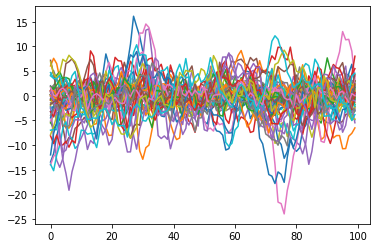

In [38]:
def gen_W(p, s, low, high, acyclic = True, regress = 0, seed = 12345):
    np.random.seed(seed)
    
    W = np.zeros((p, p))
    # randomly generate an acyclic coefficient matrix, fill diagonals
    
    if acyclic:
        # generate s off-diagonal elements uniform between +- low, high
        arcs = np.array([0.0] * (int(p * (p + 1) / 2) - s - p) + [1.0] * s)
        arcs[arcs > 0] = (2 * np.random.randint(0, 2, size=(s)) - 1) * np.random.uniform(low, high, s)
        np.random.shuffle(arcs)
    
        W[np.tril_indices(p, - 1)] = arcs
        
        P = np.random.permutation(np.identity(p))
        W = P.T @ W @ P

    #else:
        # generate acyclicly s off-diagonal elements uniform between +- low high
    
    
    # fill diagonal based on strength
    for i in range(p):
        W[i][i] = 0.5 + 0.2 * regress
        
    return W

def cov_X(W):
    
    p = np.shape(W)[0]
    # covariance matrix
    return (np.linalg.inv(np.identity(p ** 2) - np.kron(W.T, W.T)) @ np.identity(p).reshape(p ** 2)).reshape((p, p))

def expected_cost_var(W_true, W_est):
    
    p = np.shape(W_true)[0]
    
    # covariance matrix
    covariance_matrix = np.identity(p) + np.matmul((W_true - W_est).T, np.matmul(cov_X(W_true), (W_true - W_est)))
    
    # return expected MSE
    return np.trace(covariance_matrix)

def gen_var(W, T, seed = 123245):
    np.random.seed(seed)
    
    # get number of variables
    p = np.shape(W)[0]
    
    # Initialize series
    X = np.array(np.zeros((T, p)))

    # noise 
    noise = np.vstack((np.random.multivariate_normal(np.zeros(p), cov_X(W), 1), np.random.multivariate_normal(np.zeros(p), np.identity(p), T - 1)))
    X[0] = noise[0]
    
    # Generate series
    for t in range(1, T):
        # First the randomness
        X[t] = X[t - 1] @ W + noise[t]
    
    # Return series
    return X

def gen_data(p, s, T, low = 0.5, high = 0.5, regress = 0, seed = 12345):
    # generate matrix
    W = gen_W(p, min(3 * p, int(p * (p - 1) / 2)), low, high, regress = regress, seed = seed)
    
    # generate VAR(1) model in stationary distribution
    X = gen_var(W, T, seed = seed)

    return W, X, 

W, X = gen_data(p = 50, s = 50, T = 100, regress = 0, seed = 1)
print(W)
plt.plot(X);

### Generate the datasets

In [218]:
from tqdm import tqdm
datasets = []

p_range = [5, 10, 15,25, 50]

for p in tqdm(p_range):
    datasets_p = []
    for i in range(10):
        W, X = gen_data(p, 0, 1000, seed = i)
        datasets_p.append((W, X))
        # plt.plot(X)
        # plt.show()
    datasets.append(datasets_p)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:34<00:00,  6.83s/it]


### Import datasets

In [185]:
f_name = "28_06_2022_00_04_35thresholdT100sparse.pkl"
with open(f_name, 'rb') as f:
    results_W = pickle.load(f)
    
print(results_W)

{'rw_2': {'5': [array([[ 0.52539218,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.3508396 ,  0.55271145,  0.48432773,  0.        ,  0.52180297],
       [ 0.5137611 ,  0.        ,  0.45390546,  0.        ,  0.50668947],
       [-0.28613456,  0.51218088,  0.53365041,  0.59139199, -0.62942865],
       [ 0.49393228,  0.        ,  0.        ,  0.        ,  0.42615847]]), array([[ 0.5132753 ,  0.        ,  0.56513967,  0.        ,  0.        ],
       [ 0.39015249,  0.28551479,  0.38214054, -0.5418923 ,  0.63441409],
       [ 0.        ,  0.        ,  0.4826092 ,  0.        ,  0.        ],
       [ 0.4298029 ,  0.        , -0.40541619,  0.53836999,  0.48847696],
       [ 0.40840047,  0.        , -0.4628868 ,  0.        ,  0.45533274]]), array([[ 0.46005245,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.5834154 ,  0.47803986,  0.        ,  0.        ,  0.        ],
       [-0.58422357, -0.58392904,  0.60759184,  0.48392054,  0.        ],
       [-0.4291324

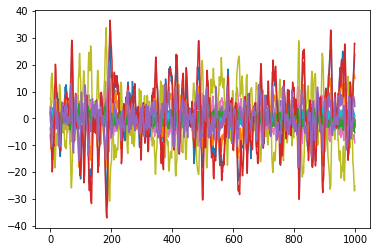

In [5]:
plt.plot(datasets[2][2][1])

In [40]:
def con_OLS(X, B):
    p = np.shape(B)[0]
    W = np.zeros((p, p))
    for i in range(p):
        X_F = X[:, B[:, i]]
        W[B[:, i], i] = np.linalg.inv(X_F[:-1].T @ X_F[:-1]) @ X_F[:-1].T @ X[1:, i]
        
    return W

In [62]:
def evaluate(results, X, W_true, W_m, method, epsilon = 0.30, verbose = True):
    W_t = W_m.copy()
    # get mse
    _, _, _, _, shd_1, mse, _ = h.score(X, W_t, W_true, printing = False)
    results[method]['mse'].append(mse)

    
    # do thresholding to get shd
    print(epsilon)
    W_t[np.abs(W_t) <= epsilon] = 0

    _, _, _, _, shd, _, _ = h.score(X, W_t, W_true, printing = False)
    results[method]['shd'].append(shd)
    
    # do reestimated to get expected mean squared error
    emse = expected_cost_var(W_true, con_OLS(X, W_t != 0))
    results[method]['emse'].append(emse)
    
    if verbose:
        print(method)
        print(f"SHD: {shd}, Empirial Risk: {round(mse, 3)}, True Risk: {round(emse, 3)}.")
        
    return results

In [219]:
# mean squared, true risk, and shd per method
results = {
    "exh": {"mse": [], "emse": [], "shd": []},
    "rw_1": {"mse": [], "emse": [], "shd": []},
    "rw_2": {"mse": [], "emse": [], "shd": []},
    "mcmc_r": {"mse": [], "emse": [], "shd": []},
    "mcmc_t": {"mse": [], "emse": [], "shd": []},
    "mcmc_s": {"mse": [], "emse": [], "shd": []},
    "mcmc_g": {"mse": [], "emse": [], "shd": []},
    "notears": {"mse": [], "emse": [], "shd": []},
    "daglasso": {"mse": [], "emse": [], "shd": []},
    "dagomp": {"mse": [], "emse": [], "shd": []},
    "dagols": {"mse": [], "emse": [], "shd": []},
}

# mean squared, true risk, and shd per method
results_W = {
    "rw_2": {"5": [], "10": [], "15": [], "25": [], "50": []},
    "mcmc_r": {"5": [], "10": [], "15": [], "25": [], "50": []},
    "mcmc_g": {"5": [], "10": [], "15": [], "25": [], "50": []},
    "notears": {"5": [], "10": [], "15": [], "25": [], "50": []},
    "daglasso": {"5": [], "10": [], "15": [], "25": [], "50": []},
    "dagomp": {"5": [], "10": [], "15": [], "25": [], "50": []},
    "dagols":{"5": [], "10": [], "15": [], "25": [], "50": []},
}


In [220]:
import time
iters = 1000

old_time = time.time()
# for each dataset
for dataset in datasets:
    print(np.shape(dataset[0][1]))
    for W, X in dataset:
        # for each method:
        T, p = np.shape(X)
        m.T, m.p = T, p
    
        # if p == 50: continue
    # covariance_X = np.matmul(np.linalg.inv(np.identity(p ** 2) - np.kron(W.T, W.T)), np.identity(p).reshape(p ** 2)).reshape((p, p))
    
    # 1: Exhaustive:
#     if p <= 8:
#         W_exh = m.exh(X[:-1], X[1:])
        
#         # 2.1: Random Walk 1, need regularizing
#         W_rw_1 = m.rw_1(X[:-1], X[1:], np.identity(p), iters)[1]
#         results = evaluate(results, X, W, W_rw_1, "rw_1")
    
    # 2.2: Random Walk 2
#         W_rw_2 = m.rw_2(X[:-1], X[1:], np.identity(p), iters)[1]
#         results_W["rw_2"][str(p)].append(W_rw_2)
    
#     # 3.1: MCMC 1
#         W_mcmc_1 = m.mcmc_1(X[:-1], X[1:], iters, np.identity(p))[1]
#         results_W["mcmc_r"][str(p)].append(W_mcmc_1)
    
#     # 3.2: MCMC 2
#     W_mcmc_2 = m.mcmc_2(X[:-1], X[1:], iters, np.identity(p))[1]
#     results = evaluate(results, X, W, W_mcmc_2, "mcmc_t")
    
#     # 3.3: MCMC 3
#     W_mcmc_3 = m.mcmc_3(X[:-1], X[1:], iters, np.identity(p))[1]
#     results = evaluate(results, X, W, W_mcmc_3, "mcmc_s")
    
#     # 3.4: MCMC 4
#         W_mcmc_4 = m.mcmc_4(X[:-1], X[1:], iters, np.identity(p))[1]
#         results_W["mcmc_g"][str(p)].append(W_mcmc_4)
    
    # 4: NO TEARS, NEED TO REGULARIZE using bootstrap.
#         W_notears, _ = m.notears_2(X, lambda1 = 0.0)
#         W_notears[np.abs(W_notears) <= 0.0001] = 0
#         results_W["notears"][str(p)].append(W_notears)
#         results = evaluate(results, X, W, W_notears, "notears")
    
#         # 5: LASSO-DAG, NEED TO REGULARIZE using bootstrap.
#         W_lassodag, alpha = m._LASSO_LINGNAM(X, step_size = 0.1)
#         results_W["daglasso"][str(p)].append(W_lassodag)
#         results = evaluate(results, X, W, W_lassodag, "daglasso")
    
    # 6: DAG-OMP, NEED TO REGULARIZE using cross-validation.
#         W_omp, _ = m._K_OMP(X[:-1], X[1:], F = [], normalize = True)
#         results_W["dagomp"][str(p)].append(W_omp)
    
#         # 7: DAG-LASSO, NEED TO REGULARIZE using bootstrap.
        W_olsdag = con_OLS(X, B_V_LINGNAM_OLS_Q2(X) != 0)
        results_W["dagols"][str(p)].append(W_olsdag)
#         results = evaluate(results, X, W, W_olsdag, "dagols")
        
print(f"Done! Took {time.time() - old_time} seconds.")

(1000, 5)
(1000, 10)
(1000, 15)
(1000, 25)
500
250
500
250
500
250
500
250
500
250
500
250
500
250
500
250
250
500
250
500
250
(1000, 50)
2500
2250
2000
1750
1500
1250
1000
750
500
500
2500
2250
2000
1750
1500
1250
1000
750
500
2500
2250
2000
1750
1500
1250
1000
750
500
500
2500
2250
2000
1750
1500
1250
1000
750
500
2500
2250
2000
1750
1500
1250
1000
750
750
500
500
500
500
2500
2250
2000
1750
1500
1250
1000
750
500
2500
2250
2000
1750
1500
1250
1000
750
500
2500
2250
2000
1750
1500
1250
1000
750
500
2500
2250
2000
1750
1500
1250
1000
750
2500
2250
2000
1750
1500
1250
1000
750
500
Done! Took 717.1217522621155 seconds.


In [199]:
print(results_W)

{'rw_2': {'5': [array([[ 0.52539218,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.3508396 ,  0.55271145,  0.48432773,  0.        ,  0.52180297],
       [ 0.5137611 ,  0.        ,  0.45390546,  0.        ,  0.50668947],
       [-0.28613456,  0.51218088,  0.53365041,  0.59139199, -0.62942865],
       [ 0.49393228,  0.        ,  0.        ,  0.        ,  0.42615847]]), array([[ 0.5132753 ,  0.        ,  0.56513967,  0.        ,  0.        ],
       [ 0.39015249,  0.28551479,  0.38214054, -0.5418923 ,  0.63441409],
       [ 0.        ,  0.        ,  0.4826092 ,  0.        ,  0.        ],
       [ 0.4298029 ,  0.        , -0.40541619,  0.53836999,  0.48847696],
       [ 0.40840047,  0.        , -0.4628868 ,  0.        ,  0.45533274]]), array([[ 0.46005245,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.5834154 ,  0.47803986,  0.        ,  0.        ,  0.        ],
       [-0.58422357, -0.58392904,  0.60759184,  0.48392054,  0.        ],
       [-0.4291324

### Plotting

In [237]:
method = "daglasso"
print(results[method])
results[method]["mse"] = []
results[method]["shd"] = []
results[method]["emse"] = []

{'mse': [], 'emse': [], 'shd': []}


In [199]:
from scipy.stats import sem

In [76]:
print(results_W["dagomp"]["5"][0])
print(datasets[0][0][0])

[[ 0.49710525  0.          0.          0.          0.        ]
 [ 0.4615438   0.50659956  0.4856737   0.          0.4844184 ]
 [ 0.50027937  0.          0.48055049  0.          0.49172578]
 [-0.47924802  0.48820526  0.4977266   0.49485162 -0.52303178]
 [ 0.52057195  0.          0.          0.          0.49077441]]
[[ 0.5  0.   0.   0.   0. ]
 [ 0.5  0.5  0.5  0.   0.5]
 [ 0.5  0.   0.5  0.   0.5]
 [-0.5  0.5  0.5  0.5 -0.5]
 [ 0.5  0.   0.   0.   0.5]]


In [120]:
print(len(results_W["rw_2"]["5"]))

12


In [202]:
for method in results_W:
    for i, p_val in enumerate(results_W[method]):
            # print(len(results_W[method][p_val]))
            # print(p_val)
            
            # if p_val == "50": continue
                
        print(len(results_W[method][p_val]))

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10


In [221]:
def evaluate_all(results_W, threshold):
    # mean squared, true risk, and shd per method
    results = {
        "rw_2": {"mse": [], "emse": [], "shd": []},
        "mcmc_r": {"mse": [], "emse": [], "shd": []},
        "mcmc_g": {"mse": [], "emse": [], "shd": []},
        "notears": {"mse": [], "emse": [], "shd": []},
        "daglasso": {"mse": [], "emse": [], "shd": []},
        "dagomp": {"mse": [], "emse": [], "shd": []},
        "dagols": {"mse": [], "emse": [], "shd": []},
    }

    for method in results_W:
        if method != "dagols": continue # and method != "notears": continue
        for i, p_val in enumerate(results_W[method]):
            # print(len(results_W[method][p_val]))
            # print(p_val)
            
            print(threshold, method, p_val)
                
            
            for j, W in enumerate(results_W[method][p_val]):
                print(np.shape(datasets[i][j][1]))
                print(p_val)
                results = evaluate(results, datasets[i][j][1], datasets[i][j][0], W, method, epsilon = threshold, verbose = False)
                
    return results

# results_threshold = {"0.00": [], "0.05": [], "0.15": [], "0.30": [], "0.40": []}

for threshold in results_threshold:
    # if threshold != "0.40": continue
    results_threshold[threshold] = evaluate_all(results_W, float(threshold))

0.0 dagols 5
(1000, 5)
5
0.0
(1000, 5)
5
0.0
(1000, 5)
5
0.0
(1000, 5)
5
0.0
(1000, 5)
5
0.0
(1000, 5)
5
0.0
(1000, 5)
5
0.0
(1000, 5)
5
0.0
(1000, 5)
5
0.0
(1000, 5)
5
0.0
0.0 dagols 10
(1000, 10)
10
0.0
(1000, 10)
10
0.0
(1000, 10)
10
0.0
(1000, 10)
10
0.0
(1000, 10)
10
0.0
(1000, 10)
10
0.0
(1000, 10)
10
0.0
(1000, 10)
10
0.0
(1000, 10)
10
0.0
(1000, 10)
10
0.0
0.0 dagols 15
(1000, 15)
15
0.0
(1000, 15)
15
0.0
(1000, 15)
15
0.0
(1000, 15)
15
0.0
(1000, 15)
15
0.0
(1000, 15)
15
0.0
(1000, 15)
15
0.0
(1000, 15)
15
0.0
(1000, 15)
15
0.0
(1000, 15)
15
0.0
0.0 dagols 25
(1000, 25)
25
0.0
(1000, 25)
25
0.0
(1000, 25)
25
0.0
(1000, 25)
25
0.0
(1000, 25)
25
0.0
(1000, 25)
25
0.0
(1000, 25)
25
0.0
(1000, 25)
25
0.0
(1000, 25)
25
0.0
(1000, 25)
25
0.0
0.0 dagols 50
(1000, 50)
50
0.0
(1000, 50)
50
0.0
(1000, 50)
50
0.0
(1000, 50)
50
0.0
(1000, 50)
50
0.0
(1000, 50)
50
0.0
(1000, 50)
50
0.0
(1000, 50)
50
0.0
(1000, 50)
50
0.0
(1000, 50)
50
0.0
0.05 dagols 5
(1000, 5)
5
0.05
(1000, 5)
5
0.05
(10

In [226]:
# print(results_threshold)
meth = "dagols"
metr = "emse"

print(meth, metr)

for threshold in results_threshold:
    for method in results_threshold[threshold]:
        
        if method == meth:
            for metric in results_threshold[threshold][method]:
                
                if metric == metr:
                    print([np.round(np.mean(results_threshold[threshold][method][metric][10*i:10*i + 10]), 2) for i in range(5)])
    # print()

dagols emse
[5.02, 10.06, 15.13, 25.27, 50.92]
[5.02, 10.05, 15.09, 25.15, 50.44]
[5.02, 10.04, 15.07, 25.1, 50.19]
[5.02, 10.04, 15.07, 25.1, 50.19]
[5.02, 10.04, 15.07, 25.1, 50.19]


In [258]:
import matplotlib

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 8
})

matplotlib.rcParams['axes.unicode_minus'] = False


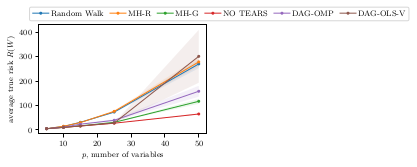

In [360]:
plt.figure(figsize = (3.0, 2.0))
plt.xlabel("$p$, number of variables")
# plt.ylabel("average empirical risk " + r"$R_{\mathrm{emp}}(W)$")
plt.ylabel("average true risk " + r"$R(W)$")
# plt.ylabel("average SHD$")
def plot_results(method, metric, results, method_name, linestyle = '-'):
    # plot mean and standard error of DAG-OMP as a function of p.
    plt.plot(p_range, [np.mean(results[method][metric][10*i:10*i + 10]) for i in range(5)], marker = 'o', markersize = 2, linewidth = 1, label = method_name, linestyle = linestyle)
    plt.fill_between(p_range, [np.mean(results[method][metric][10*i:10*i + 10]) - sem(results[method][metric][10*i:10*i + 10])for i in range(5)], [np.mean(results[method][metric][10*i:10*i + 10]) + sem(results[method][metric][10*i:10*i + 10])for i in range(5)], alpha = 0.1)

metric = "emse"

plot_results("rw_2", metric, results, "Random Walk")
plot_results("mcmc_r", metric, results, "MH-R")
plot_results("mcmc_g", metric, results, "MH-G")

plot_results("notears", metric, results, "NO TEARS")
plot_results("dagomp", metric, results, "DAG-OMP")
plot_results("dagols", metric, results, "DAG-OLS-V")

# plot_results("daglasso", metric, results, "DAG-LASSO")
plt.legend(ncol = 6, loc = 'upper left', bbox_to_anchor=(-0.08, 1.2), columnspacing = 0.75, handletextpad = 0.25)
plt.savefig("empriskresultsacyclicT100denseemse.pgf", bbox_inches = 'tight')

In [ ]:
a_file = open(f"{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}sparseT1000notearslasso.pkl", "wb")
pickle.dump(results, a_file)
a_file.close()

In [217]:
from datetime import datetime
a_file = open(f"{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}thresholdT100sparseWP50OLSNW.pkl", "wb")
pickle.dump(results_W, a_file)
a_file.close()

In [375]:
a_file = open(f"{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}sparseT1000notearslasso.pkl", "wb")
pickle.dump(results, a_file)
a_file.close()

In [135]:
print(results)

{'exh': {'mse': [], 'emse': [], 'shd': []}, 'rw_1': {'mse': [15.51930938321329, 14.924349291129303, 13.660942854655335], 'emse': [17.516740093308872, 15.401844761611144, 14.704537659885943], 'shd': [8, 5, 7]}, 'rw_2': {'mse': [13.999709388260959, 12.228860513658205, 11.009037499064128], 'emse': [16.00566941217162, 12.829642876442566, 11.46746177572549], 'shd': [8, 5, 3]}, 'mcmc_r': {'mse': [12.024503788670984, 13.31533144689828, 11.482735353102102], 'emse': [13.335378788807015, 13.635525214870079, 11.938330731617661], 'shd': [3, 6, 4]}, 'mcmc_t': {'mse': [13.613771055732878, 13.922145699454504, 13.337233489153268], 'emse': [18.70094473651455, 14.918398467202367, 14.102116452002623], 'shd': [8, 9, 6]}, 'mcmc_s': {'mse': [15.12822142217938, 12.884178708481915, 13.69909986030214], 'emse': [17.585350786235104, 14.172125584287423, 13.930770954147391], 'shd': [9, 5, 4]}, 'mcmc_g': {'mse': [15.401595274960952, 11.349025040383523, 10.744590216335688], 'emse': [16.325961093178222, 12.0083041498

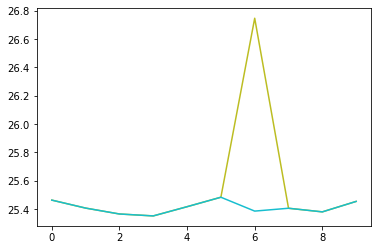

In [160]:
for method in results:
    for metric in results[method]:
        if metric == "emse" and method != "daglasso":
            plt.plot(results[method][metric])

In [195]:
import statsmodels.api as sm
import scipy.linalg as slin

def _h(W):
    """Evaluate value and gradient of acyclicity constraint."""
    W2 = W.copy()

    np.fill_diagonal(W2, np.zeros(np.shape(W)[0]))

    E = slin.expm(W2)  # (Zheng et al. 2018)
    h = np.trace(E) - p

    return h
    
def get_all_violating_edges(W, epsilon = 1e-16):
   
    h_val = _h(W)
    
    violators = set()
    
    for i in range(p):
        for j in range(p):
            if W[i][j] != 0:
                # remove Wij
                tmp = W[i][j]
                W[i][j] = 0
            
                # check h
                h_diff = h_val - _h(W)
            
                # check change
                if np.abs(h_diff) > epsilon:
                    violators.add((i, j))
            
                # add Wij back
                W[i][j] = tmp

    return violators

def B_V_LINGNAM_OLS(X, tol = 0.0):
    """OLS solution W, data X"""
    
    def OLS(X):
        # get regressor and variables
        y = X[1:]
        x = X[:-1]

        # initialize W_hat
        W_hat = np.array([])

        # get parameters
        for i in range(p):
            est = sm.OLS(y[:, i], x).fit()
            W_hat = np.append(W_hat, est.params)

        # return W
        return W_hat.reshape((p, p)).T
    
    # get full OLS solution of W
    W = OLS(X)
    
    # get order of importance
    order_of_importance = []
    
    # scores
    scores = []
    
    # while we still do not have a DAG
    while not h.is_dag(W):       
        print(np.sum(W != 0))
        # get all violating edges
        violators = get_all_violating_edges(W)
        
        # find edge with smallest coefficient
        smallest_coef = np.min([np.abs(W[row][col]) for row, col in violators])
        row, col = np.where(np.abs(W) == smallest_coef)
        row, col = row[0], col[0]
    
        # set this edge to zero
        W[row][col] = 0
        
        # update column
        idx = np.nonzero(W[:, col])[0]
        W[idx, col] = (np.linalg.inv(X[:-1, idx].T @ X[:-1, idx]) @ X[:-1, idx].T @ X[1:, col])
        
        # add edge and score to list
        # order_of_importance.append([row, col])
        # scores.append(h.MSE(W, X))
    
    # we have a dag, return this one for now
    W_return = W.copy()
    
    # Now that we have a DAG, we will greedily remove the least important edge
#     while len(np.nonzero(W)[0]) > 0:   
        
#         # set zero values to impossible value
#         W[W == 0] = 1e10
        
#         # get smallest nonzero coefficient in absolute value
#         row, col = np.argmin(np.abs(W)) // p, np.argmin(np.abs(W)) % p
        
#         # set this to zero
#         W[row][col] = 0
        
#         # revert the zero values back to zero
#         W[W == 1e10] = 0

#         edge = [row, col]
        
#         # update column
#         idx = np.nonzero(W[:, col])[0]
#         W[idx, col] = (np.linalg.inv(X[:-1, idx].T @ X[:-1, idx]) @ X[:-1, idx].T @ X[1:, col])
        
#         score = h.MSE(W, X)
        
#         if score < tol: 
#             break
            
#         order_of_importance.append(edge)
#         scores.append(h.MSE(W, X))
        
    # return the DAG W
    return W_return # , order_of_importance, scores

W_B_V_LINGNAM_OLS = B_V_LINGNAM_OLS(X)
# print(f"OLS solution after iteratively removing the least important violators until we have a DAG:\n{np.round(W_B_V_LINGNAM_OLS, 2)}.")
# print(f"Importance of the removed edges, from least to most important:\n{edge_order}.")
print(W_B_V_LINGNAM_OLS)
plt.figure(figsize = (12, 4))
plt.plot(np.flip(scores))

IndexError: index 5 is out of bounds for axis 1 with size 5

In [178]:
W_m = W_B_V_LINGNAM_OLS.copy()

In [182]:
_, _, _, _, shd_1, mse, _ = h.score(X, W_m, W, printing = False)
# results[method]['mse'].append(mse)


# do thresholding to get shd
W_m[np.abs(W_m) <= 0.30] = 0

_, _, _, _, shd, _, _ = h.score(X, W_m, W, printing = False)
# results[method]['shd'].append(shd)

# do reestimated to get expected mean squared error
emse = expected_cost_var(W, con_OLS(X, W_m != 0))
# results[method]['emse'].append(emse)

if True:
    # print(method)
    print(f"SHD: {shd}, Empirial Risk: {round(mse, 3)}, True Risk: {round(emse, 3)}.")


SHD: 0, Empirial Risk: 24.691, True Risk: 25.408.


In [197]:
def _h(W):
    """Evaluate value and gradient of acyclicity constraint."""
    W2 = W.copy()

    np.fill_diagonal(W2, np.zeros(np.shape(W)[0]))

    E = slin.expm(W2)  # (Zheng et al. 2018)
    h = np.trace(E) - p

    return h

def in_cycle(W, i, j, epsilon = 1e-32):
    
    h_val = _h(W)
    
    w_tmp = W[i][j]
    W[i][j] = 0
    h_new = _h(W)
    W[i][j] = w_tmp
    
    return np.abs(h_val - h_new) > epsilon

def B_V_LINGNAM_OLS_Q2(X, tol = 0.0):
    """OLS solution W, data X"""
    
    def OLS(X):
        # get regressor and variables
        y = X[1:]
        x = X[:-1]

        # initialize W_hat
        W_hat = np.array([])

        # get parameters
        for i in range(p):
            est = sm.OLS(y[:, i], x).fit()
            W_hat = np.append(W_hat, est.params)

        # return W
        return W_hat.reshape((p, p)).T
    
    T, p = np.shape(X)
    
    # compute kernel spaces
    Psi = X[:-1].T.dot(X[:-1])
    K = X[:-1].T.dot(X[1:])
    
    # get full OLS solution of W
    W = np.linalg.inv(Psi) @ K
    
    # non_violators
    violators = np.ones((p, p))
    
    # while we still do not have a DAG
    while not h.is_dag(W):     
        if np.sum(W != 0) % 250 == 0: print(np.sum(W != 0))
        # print(h.is_dag(W))
        
        # find edge with smallest coefficient which might be a violator
        i_list, j_list = np.where((np.abs(W) == np.min(np.abs(W[(W * violators).nonzero()]))))
        i, j = i_list[0], j_list[0]
        
        # if it is contained in a cycle, remove it
        # if not, never consider it again
        if in_cycle(W, i, j):
            W[i][j] = 0
            violators[i][j] = 0
        
            # update column
            idx = np.nonzero(W[:, j])[0]
            Psi_F = Psi[np.array(idx)[:, None], np.array(idx)[None, :]]
            W[np.array(idx)[:, None], j] = np.linalg.inv(Psi_F) @ K[np.array(idx)[:, None], j]
        else:
            violators[i][j] = 0
  
    return W
    # return the DAG W
    Ws = [W.copy()]

X = datasets[0][3][1]
print(B_V_LINGNAM_OLS_Q2(X))
# print(B_V_LINGNAM_OLS_Q(X)[-3])

[[ 0.49262334 -0.50385815  0.         -0.30167845 -0.46164265]
 [ 0.          0.5249989   0.         -0.39553127  0.        ]
 [ 0.68375987  0.39265282  0.36571713  0.318374   -0.76086454]
 [ 0.          0.          0.          0.62419945  0.        ]
 [ 0.          0.47518415  0.          0.38643369  0.44538093]]
